In [16]:
from torch.utils.data import DataLoader
from dataset.data_loader import FontTransferDataset
from torch.utils.data import default_collate
# Define label space (62 characters)
label_space = [chr(i) for i in range(ord('0'), ord('9') + 1)] + \
              [chr(i) for i in range(ord('A'), ord('Z') + 1)] + \
              [chr(i) for i in range(ord('a'), ord('z') + 1)]

train_dataset = FontTransferDataset("./data/train_font_data.pkl", label_space)
valid_dataset = FontTransferDataset("./data/valid_font_data.pkl", label_space)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=default_collate)
valid_loader = DataLoader(valid_dataset, batch_size=64, collate_fn=default_collate)

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim

class FontTransferCVAE(nn.Module):
    def __init__(self, label_dim=62, latent_dim=64):
        super().__init__()
        self.latent_dim = latent_dim

        # Style Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),  # -> 14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # -> 7x7
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 256),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim + label_dim, 256)
        self.decoder = nn.Sequential(
            nn.ReLU(),
            nn.Linear(256, 64 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  # -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1),   # -> 28x28
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, label_onehot):
        z_cat = torch.cat([z, label_onehot], dim=1)
        return self.decoder(self.decoder_input(z_cat))

    def forward(self, style_img, label_onehot):
        mu, logvar = self.encode(style_img)
        z = self.reparameterize(mu, logvar)
        recon_img = self.decode(z, label_onehot)
        return recon_img, mu, logvar

def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='mean')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    return recon_loss + kl_loss, recon_loss.item(), kl_loss.item()



In [18]:
torch.mps.is_available()

True

In [19]:

device = torch.device("mps" if torch.mps.is_available() else "cpu")
model = FontTransferCVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(20):
    model.train()
    total_loss = 0
    for style_img, label_onehot, target_img in train_loader:
        style_img, label_onehot, target_img = style_img.to(device), label_onehot.to(device), target_img.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = model(style_img, label_onehot)
        loss, r_loss, kl = vae_loss(recon, target_img, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")

Epoch 1, Loss: 0.1774
Epoch 2, Loss: 0.0791
Epoch 3, Loss: 0.0698
Epoch 4, Loss: 0.0674
Epoch 5, Loss: 0.0668
Epoch 6, Loss: 0.0666
Epoch 7, Loss: 0.0662
Epoch 8, Loss: 0.0660
Epoch 9, Loss: 0.0656
Epoch 10, Loss: 0.0653
Epoch 11, Loss: 0.0648
Epoch 12, Loss: 0.0640
Epoch 13, Loss: 0.0628
Epoch 14, Loss: 0.0611
Epoch 15, Loss: 0.0590
Epoch 16, Loss: 0.0574
Epoch 17, Loss: 0.0556
Epoch 18, Loss: 0.0540
Epoch 19, Loss: 0.0521
Epoch 20, Loss: 0.0502


In [5]:
torch.save(model.state_dict(), "./data/cvae_font_transfer.pth")

In [20]:
# model = FontTransferCVAE(label_dim=62)
# model.load_state_dict(torch.load("./data/cvae_font_transfer.pth"))
model.to(device)
model.eval()

FontTransferCVAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=3136, out_features=256, bias=True)
    (6): ReLU()
  )
  (fc_mu): Linear(in_features=256, out_features=64, bias=True)
  (fc_logvar): Linear(in_features=256, out_features=64, bias=True)
  (decoder_input): Linear(in_features=126, out_features=256, bias=True)
  (decoder): Sequential(
    (0): ReLU()
    (1): Linear(in_features=256, out_features=3136, bias=True)
    (2): ReLU()
    (3): Unflatten(dim=1, unflattened_size=(64, 7, 7))
    (4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): Sigmoid()
  )
)

In [21]:
from eval import *
test_dataset = FontTransferDataset("./data/test_font_data.pkl", label_space)
test_loader = DataLoader(test_dataset, batch_size=64)


64

In [36]:
for batch in test_loader:
    # print(type(batch))
    # print(batch))
    for i in batch:
        print(i.shape)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64, 62])
torch.Size([64, 1, 28, 28])


TypeError: list indices must be integers or slices, not str

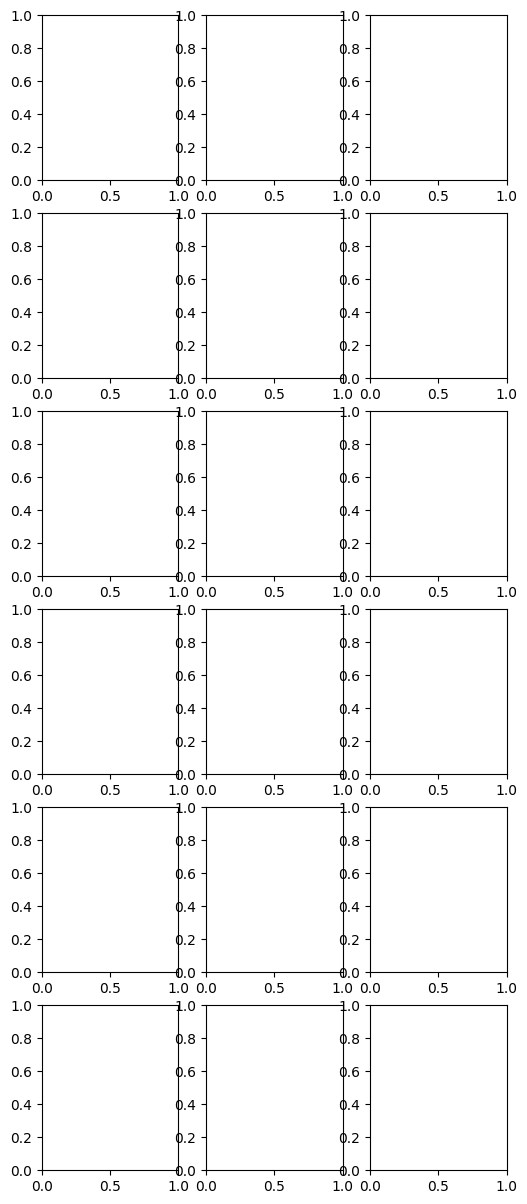

In [23]:

# Visualize inference on first 6 test samples
samples_to_show = 6
count = 0
fig, axes = plt.subplots(samples_to_show, 3, figsize=(6, 2.5 * samples_to_show))

with torch.no_grad():
    for batch in test_loader:
        style_img = batch["style_image"].to(device)           # [1, 1, 28, 28]
        target_img = batch["target_image"].to(device)
        label = batch["target_label"][0]
        onehot = label_to_onehot(label).unsqueeze(0).to(device)

        recon_img, _, _ = model(style_img, onehot)

        # Visualization
        axes[count, 0].imshow(style_img[0].cpu().squeeze(), cmap='gray')
        axes[count, 0].set_title("Style Input")
        axes[count, 1].imshow(target_img[0].cpu().squeeze(), cmap='gray')
        axes[count, 1].set_title(f"Target '{label}'")
        axes[count, 2].imshow(recon_img[0].cpu().squeeze(), cmap='gray')
        axes[count, 2].set_title("Reconstruction")

        for ax in axes[count]:
            ax.axis('off')

        count += 1
        if count == samples_to_show:
            break

plt.tight_layout()
plt.show()
